<a href="https://colab.research.google.com/github/Isaac-Gregory/House-Pricing-SWD/blob/main/housepricing_noiseanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Isaac Gregory and Bibek Lamsal

**House Pricing** *for SWD Course*

Noisy Feature Analysis

##Imports and Dataset

In [ ]:
from google.colab import files
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import copy as cp

In [ ]:
# Import kaggle.json file
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Load dataset
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 78.0MB/s]


In [ ]:
# Unzipping data from file
!unzip house-prices-advanced-regression-techniques.zip

Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [32]:
# Reading in the CSV
data = pd.read_csv('train.csv')
data.drop(['Id'], axis=1, inplace=True)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


##Preprocessing

In [33]:
def CategorizeStringColumns(og_data):
  # Copying so that the original data object isn't overwritten
  data = cp.deepcopy(og_data)

  # Splitting the numerical and categorical features
  cat_cols = data.select_dtypes(include=['object']).columns.tolist()
  num_cols = data.select_dtypes(include=['number']).columns.tolist()

  # Ensuring there are no overlapping features
  shared_cols = list(set(cat_cols) & set(num_cols))
  if shared_cols != None and shared_cols != []:
    print("Shared:", shared_cols)
    return None

  # Encoding all categorical features
  encoder_list = {}
  for col in cat_cols:
    encoder = LabelEncoder()
    data[col] = encoder.fit_transform(data[col])
    encoder_list[col] = encoder

  return data, encoder_list

In [44]:
# Calling the above function to ensure numerical data in dataset
encoded_data, encoders = CategorizeStringColumns(data)
encoded_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.0,8450,1,2,3,3,0,4,...,0,3,4,4,0,2,2008,8,4,208500
1,20,3,80.0,9600,1,2,3,3,0,2,...,0,3,4,4,0,5,2007,8,4,181500
2,60,3,68.0,11250,1,2,0,3,0,4,...,0,3,4,4,0,9,2008,8,4,223500
3,70,3,60.0,9550,1,2,0,3,0,0,...,0,3,4,4,0,2,2006,8,0,140000
4,60,3,84.0,14260,1,2,0,3,0,2,...,0,3,4,4,0,12,2008,8,4,250000


##Noise Analysis

      MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
0             60         3         65.0     8450       1      2         3   
1             20         3         80.0     9600       1      2         3   
2             60         3         68.0    11250       1      2         0   
3             70         3         60.0     9550       1      2         0   
4             60         3         84.0    14260       1      2         0   
...          ...       ...          ...      ...     ...    ...       ...   
1455          60         3         62.0     7917       1      2         3   
1456          20         3         85.0    13175       1      2         3   
1457          70         3         66.0     9042       1      2         3   
1458          20         3         68.0     9717       1      2         3   
1459          20         3         75.0     9937       1      2         3   

      LandContour  Utilities  LotConfig  ...  ScreenPorch  PoolArea  PoolQC

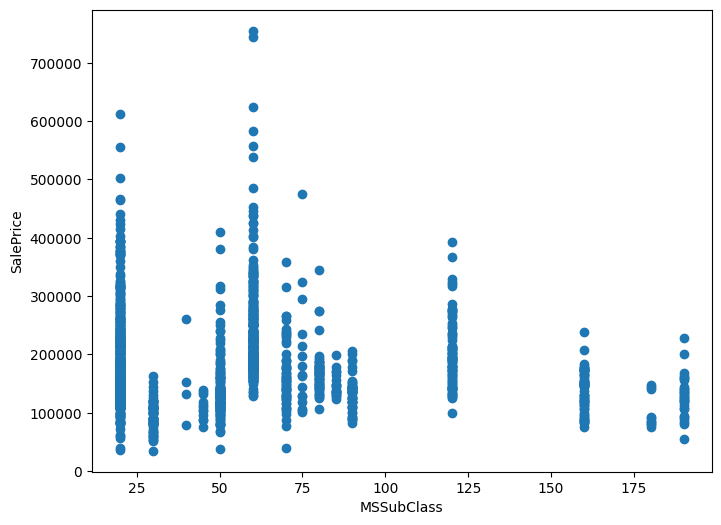

<Figure size 640x480 with 0 Axes>

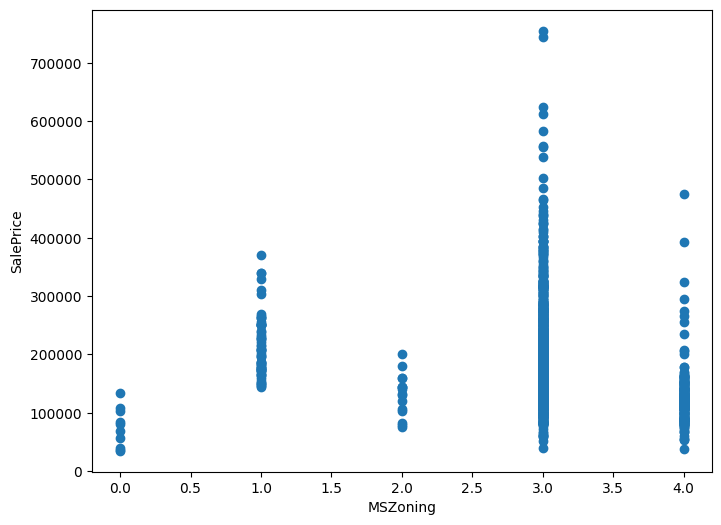

<Figure size 640x480 with 0 Axes>

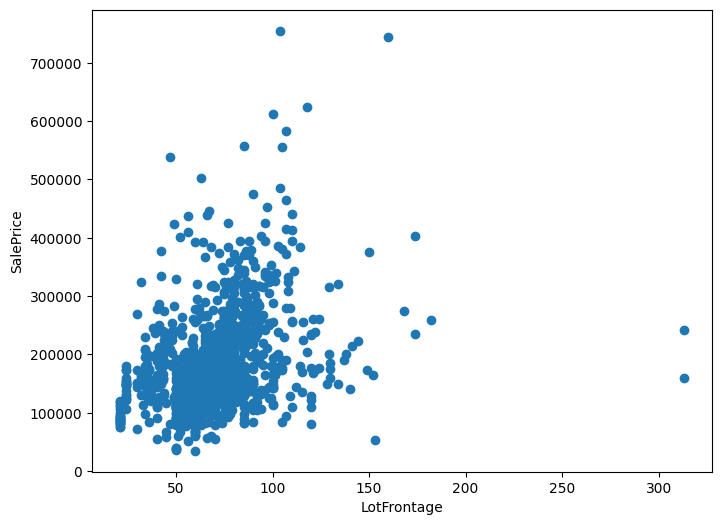

<Figure size 640x480 with 0 Axes>

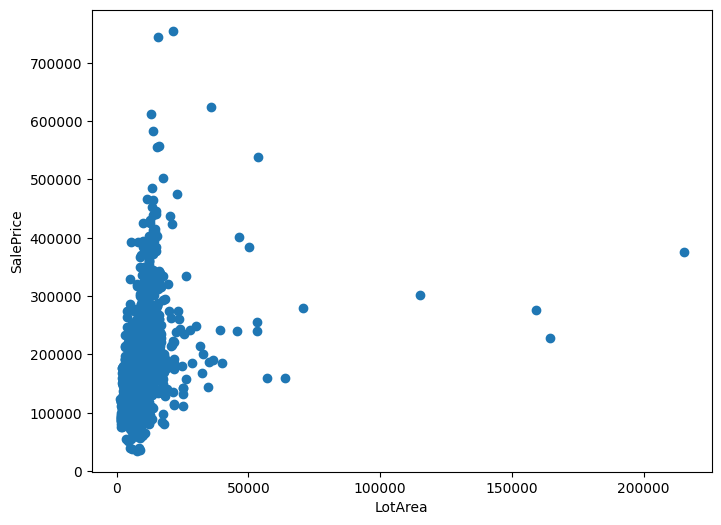

<Figure size 640x480 with 0 Axes>

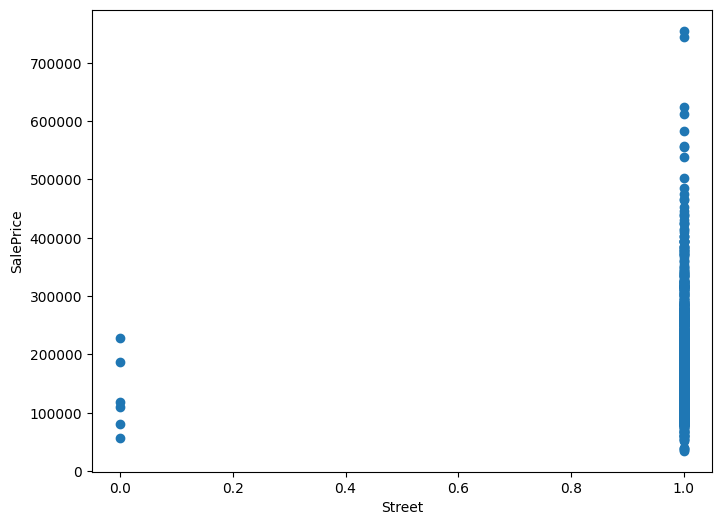

<Figure size 640x480 with 0 Axes>

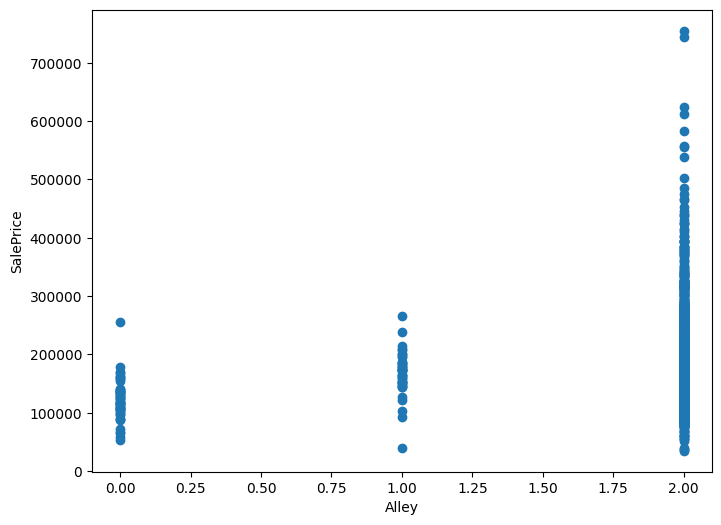

<Figure size 640x480 with 0 Axes>

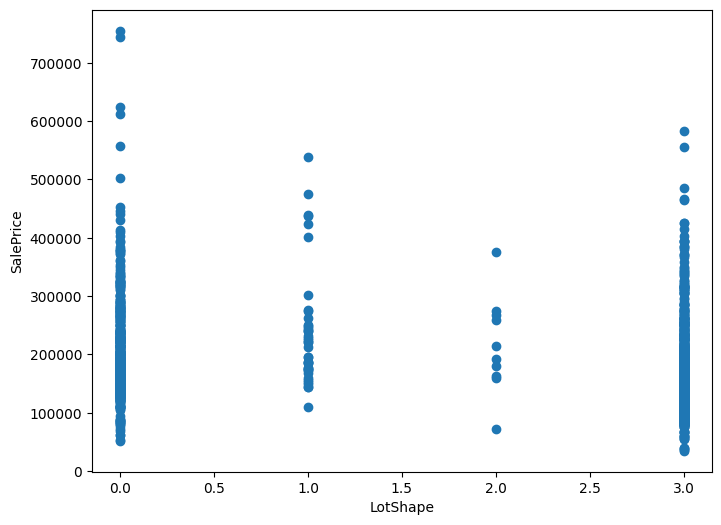

<Figure size 640x480 with 0 Axes>

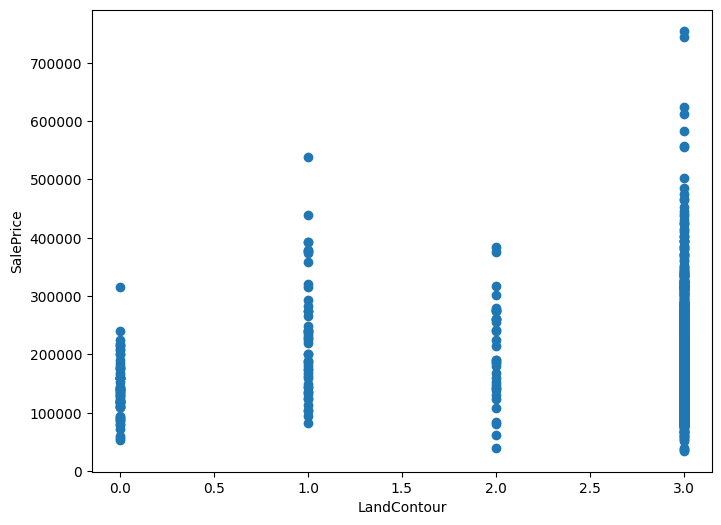

<Figure size 640x480 with 0 Axes>

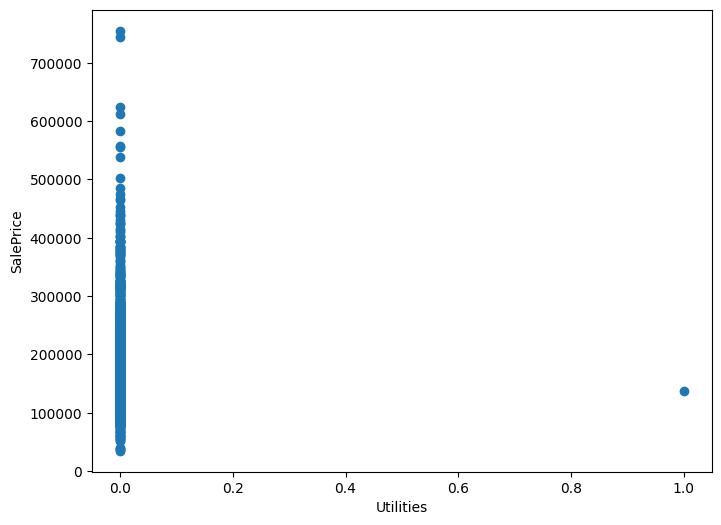

<Figure size 640x480 with 0 Axes>

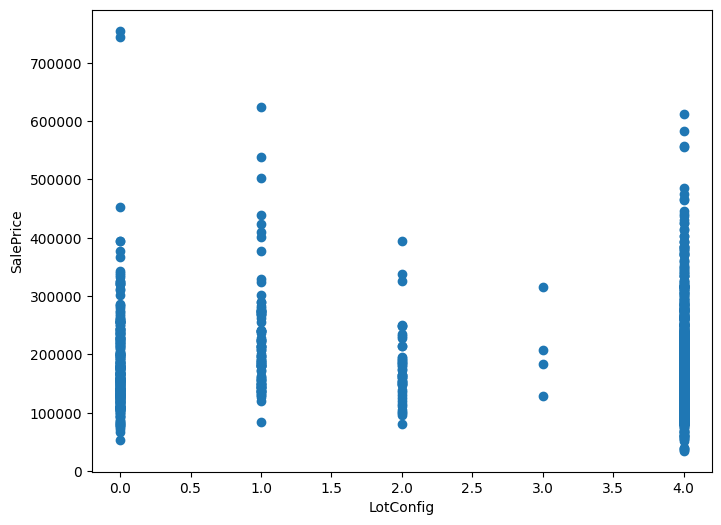

<Figure size 640x480 with 0 Axes>

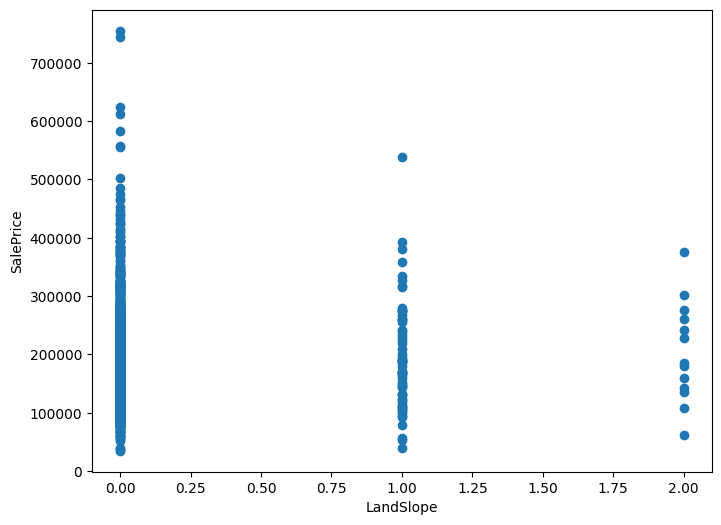

<Figure size 640x480 with 0 Axes>

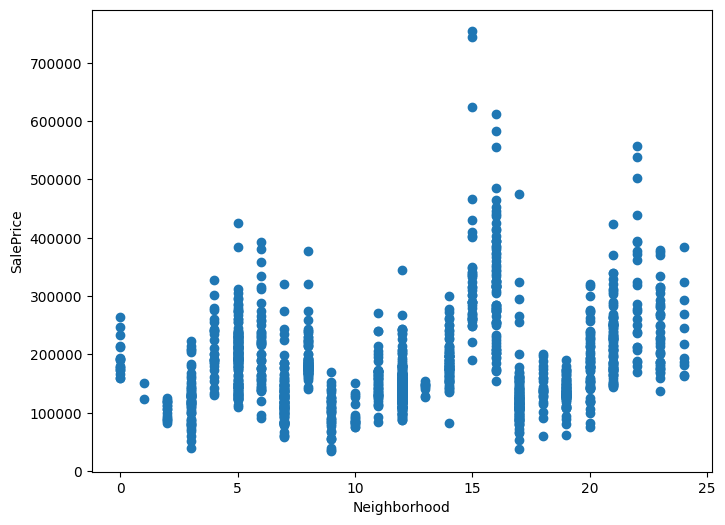

<Figure size 640x480 with 0 Axes>

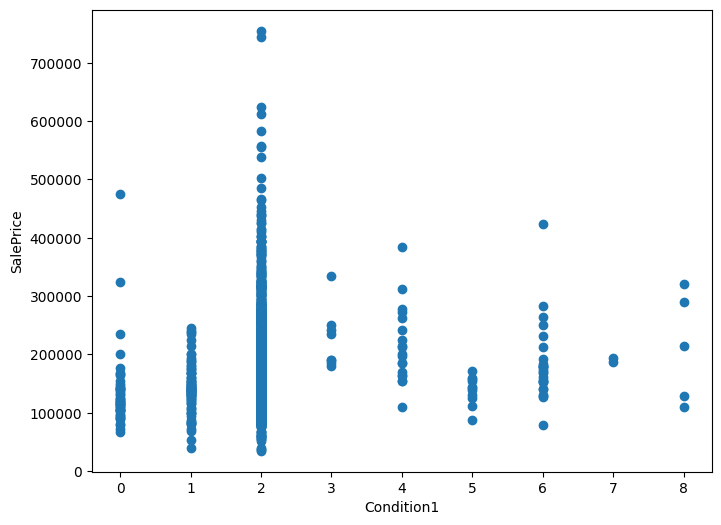

<Figure size 640x480 with 0 Axes>

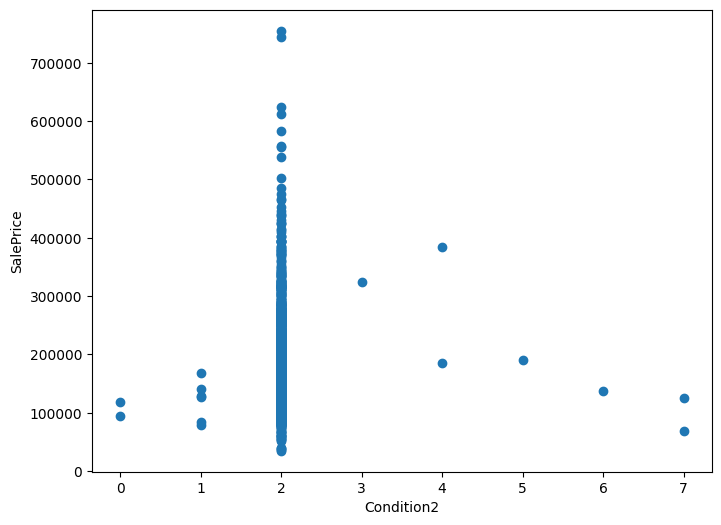

<Figure size 640x480 with 0 Axes>

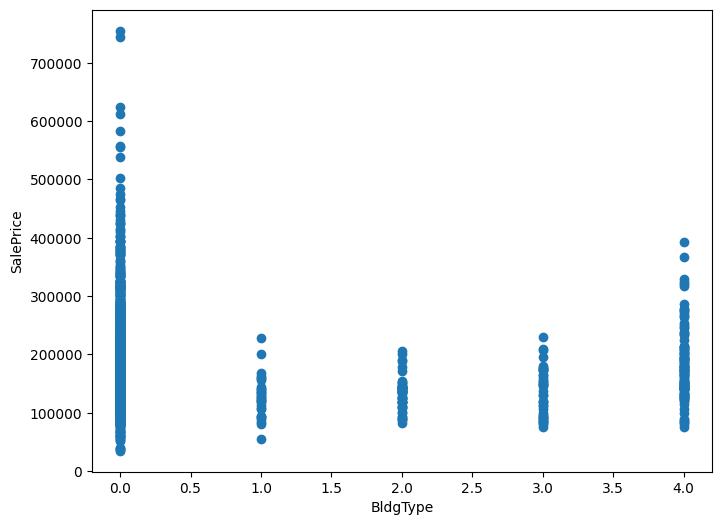

<Figure size 640x480 with 0 Axes>

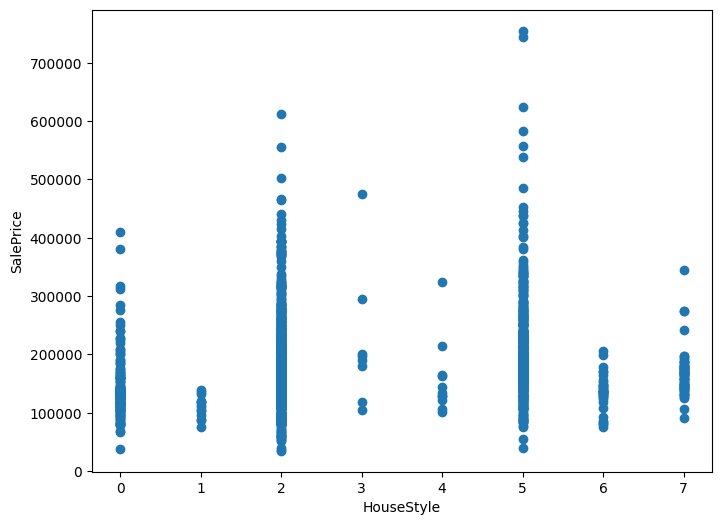

<Figure size 640x480 with 0 Axes>

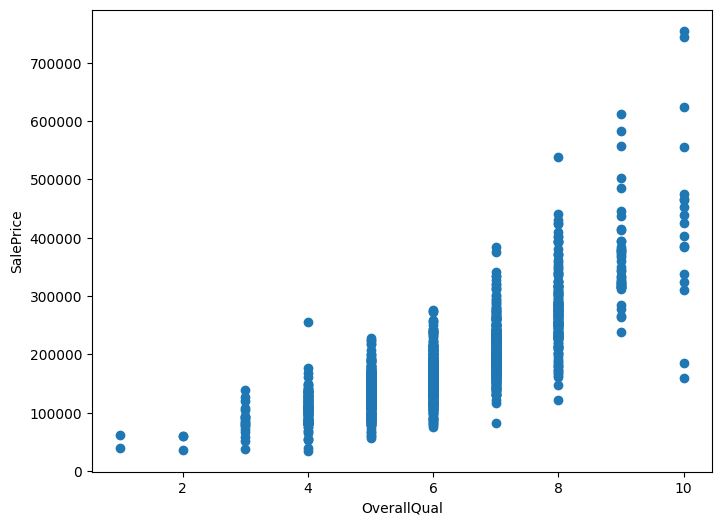

<Figure size 640x480 with 0 Axes>

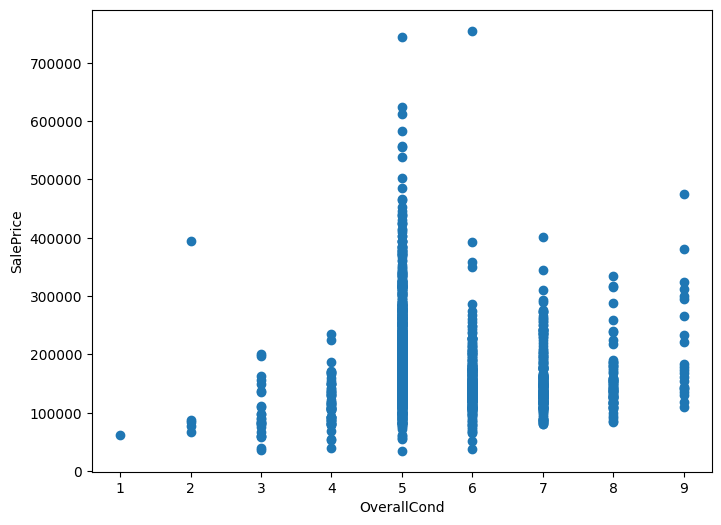

<Figure size 640x480 with 0 Axes>

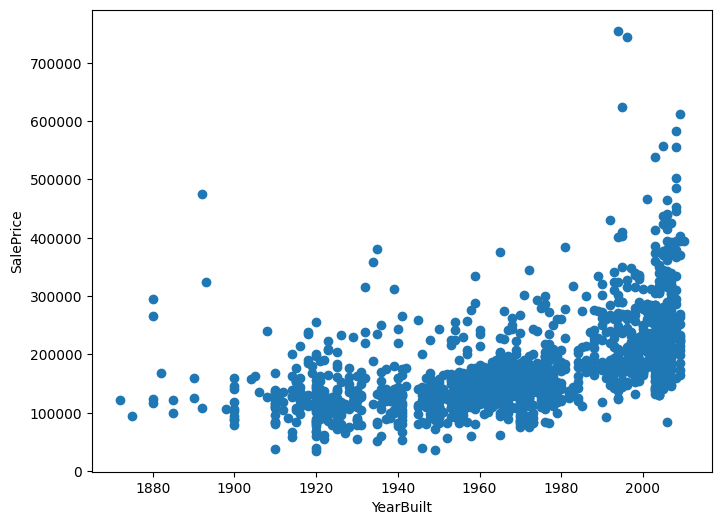

<Figure size 640x480 with 0 Axes>

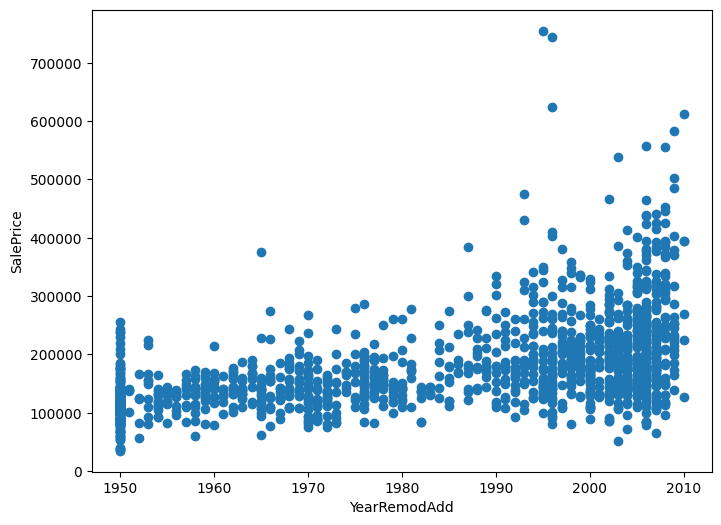

<Figure size 640x480 with 0 Axes>

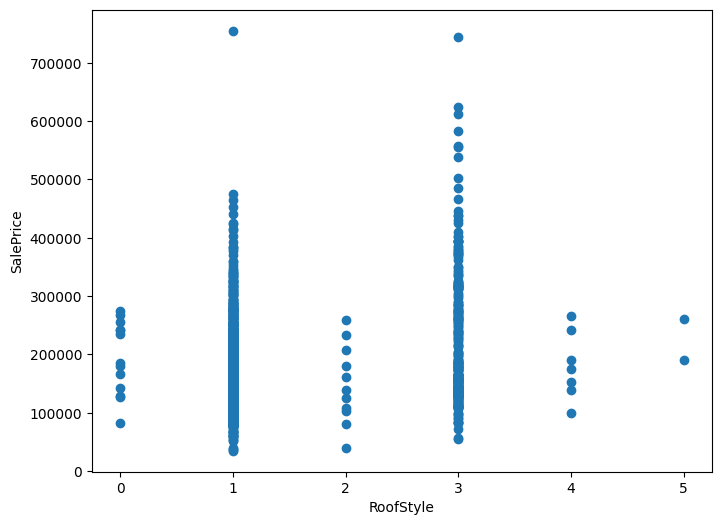

<Figure size 640x480 with 0 Axes>

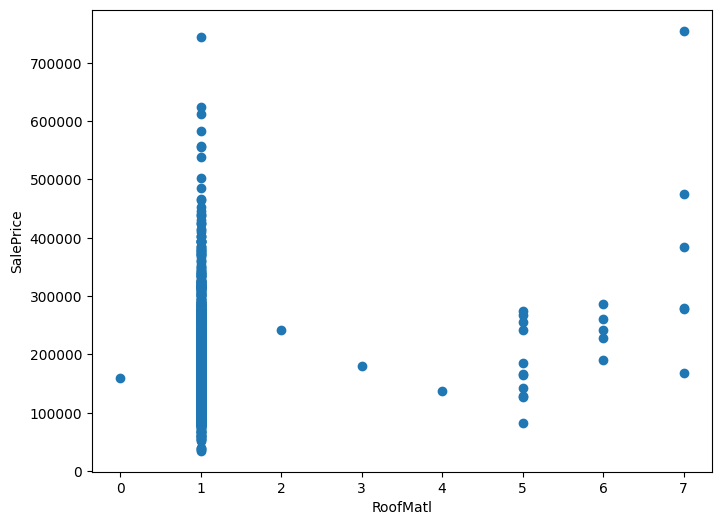

<Figure size 640x480 with 0 Axes>

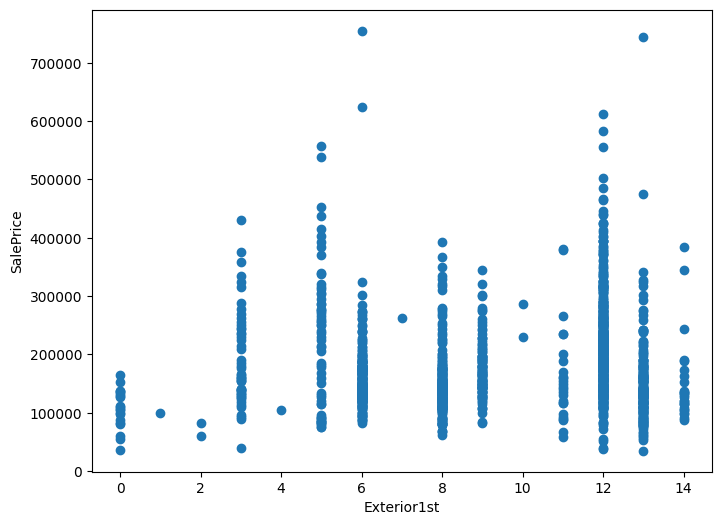

<Figure size 640x480 with 0 Axes>

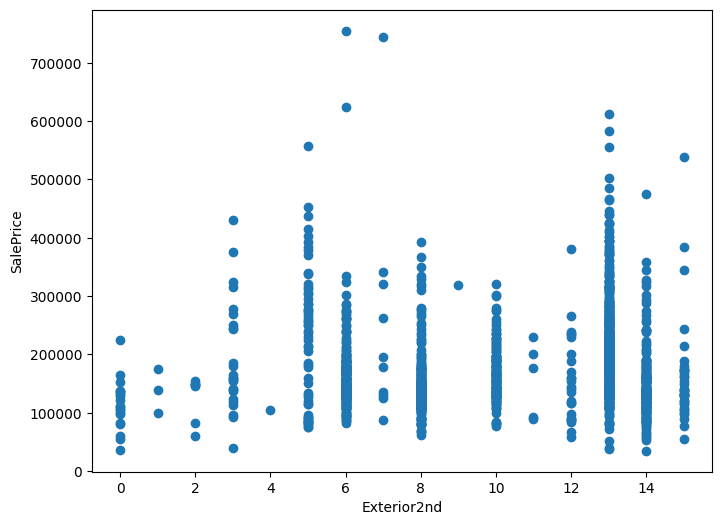

<Figure size 640x480 with 0 Axes>

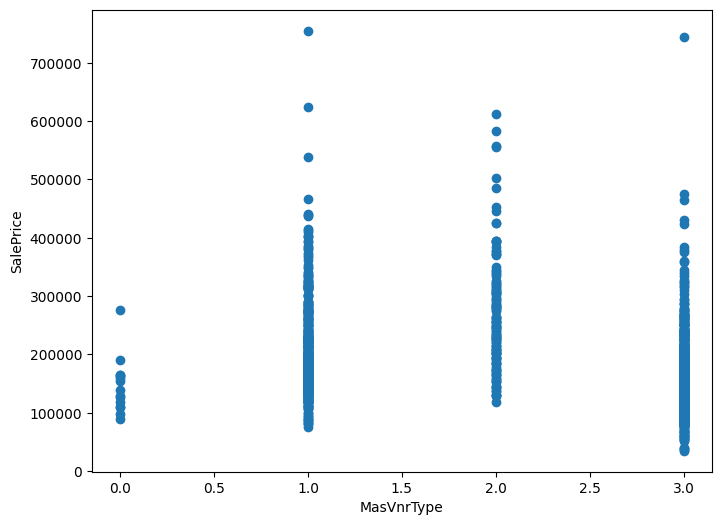

<Figure size 640x480 with 0 Axes>

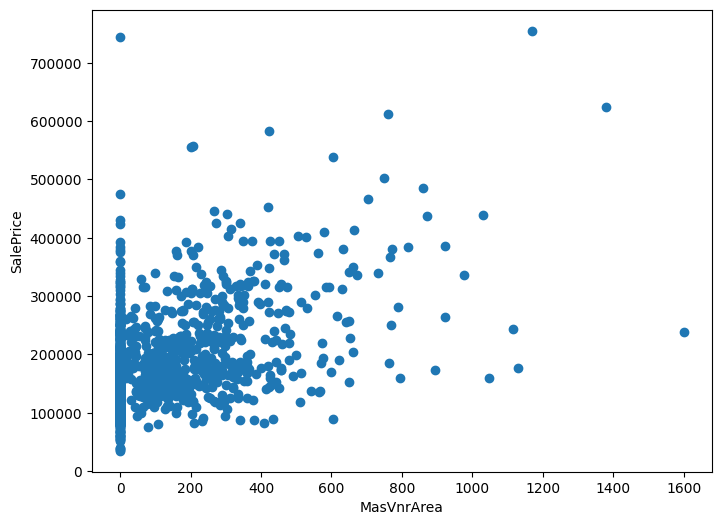

<Figure size 640x480 with 0 Axes>

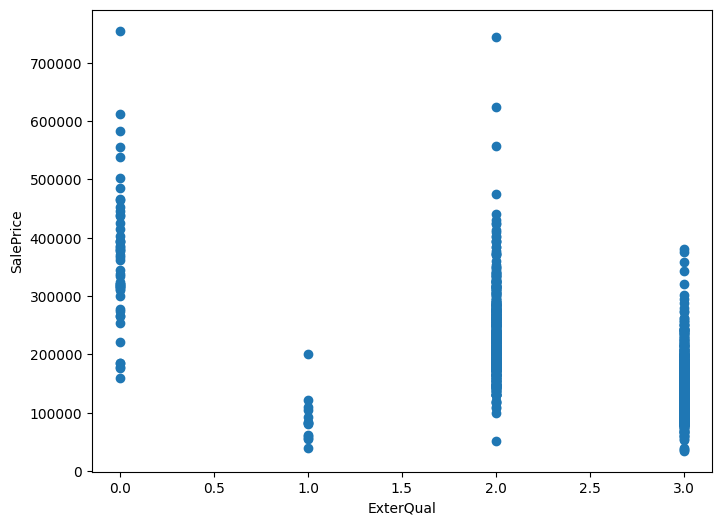

<Figure size 640x480 with 0 Axes>

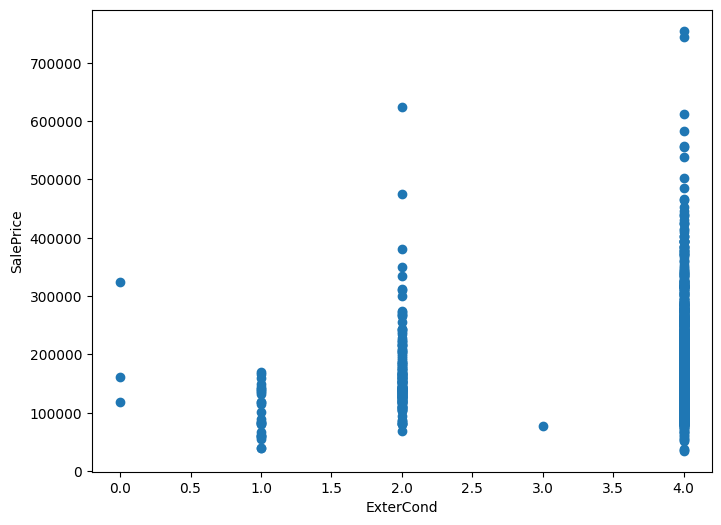

<Figure size 640x480 with 0 Axes>

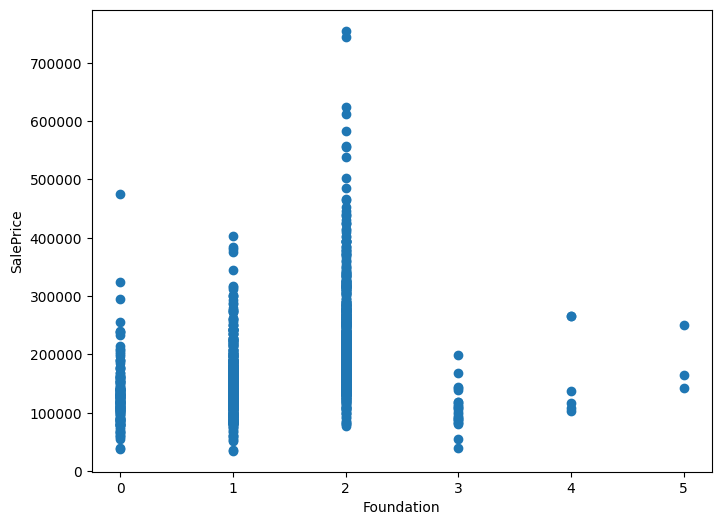

<Figure size 640x480 with 0 Axes>

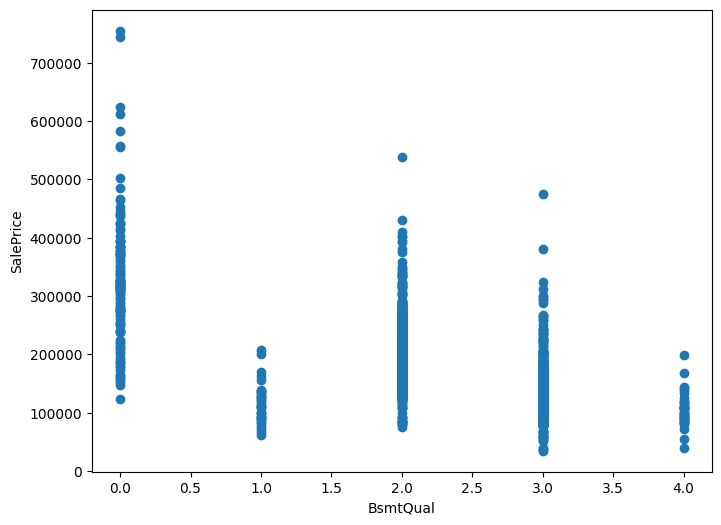

<Figure size 640x480 with 0 Axes>

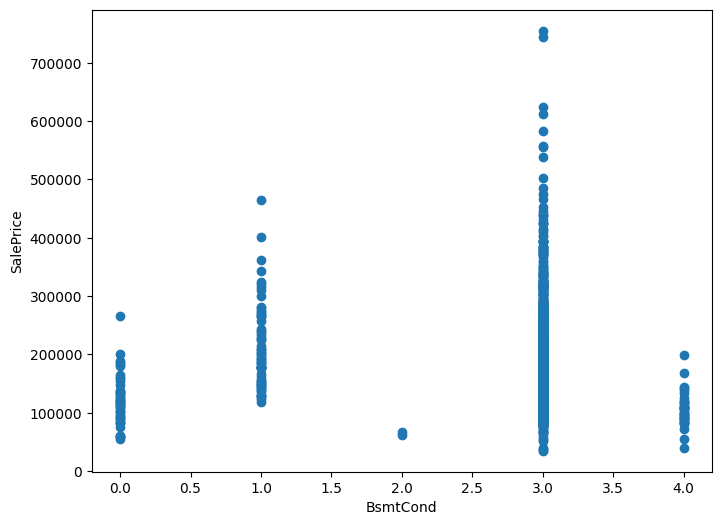

<Figure size 640x480 with 0 Axes>

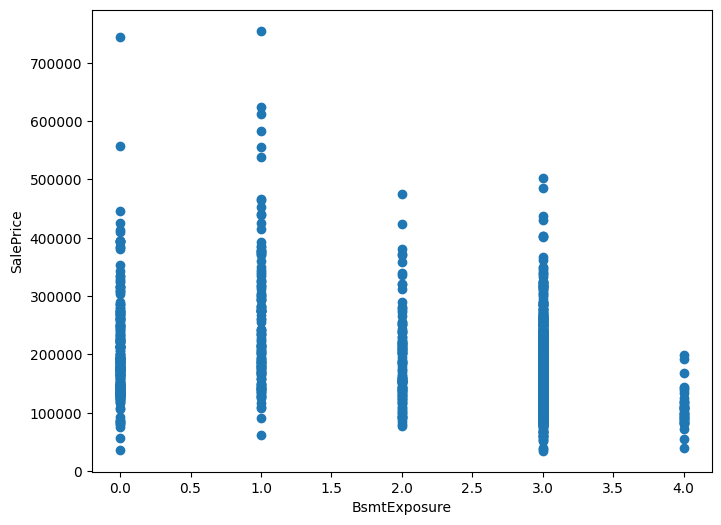

<Figure size 640x480 with 0 Axes>

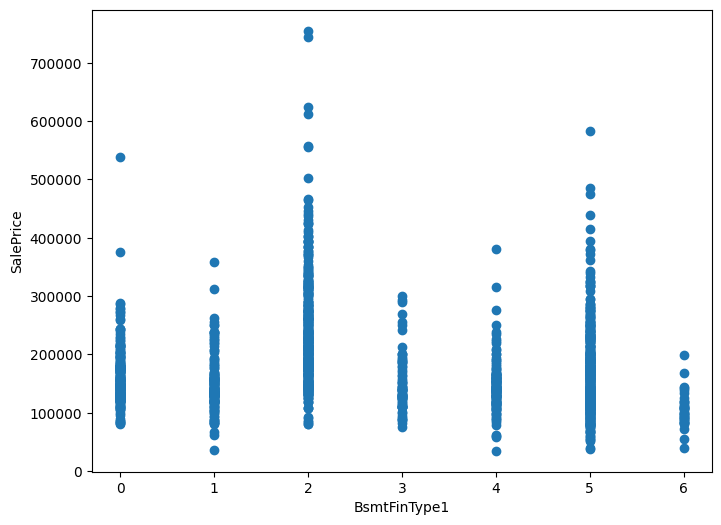

<Figure size 640x480 with 0 Axes>

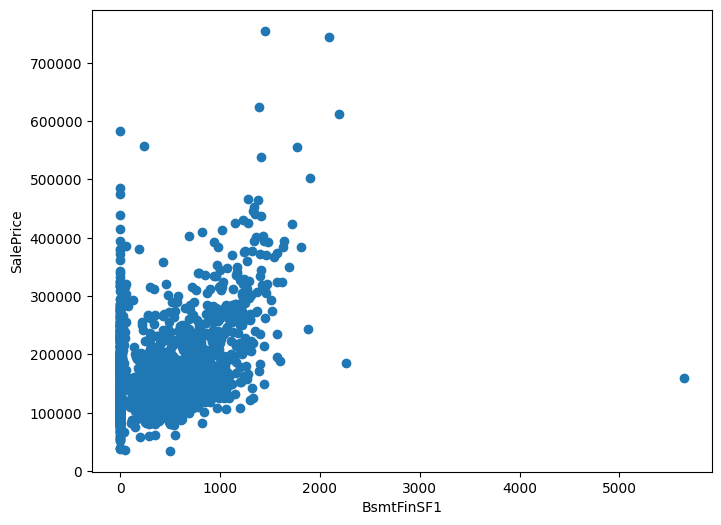

<Figure size 640x480 with 0 Axes>

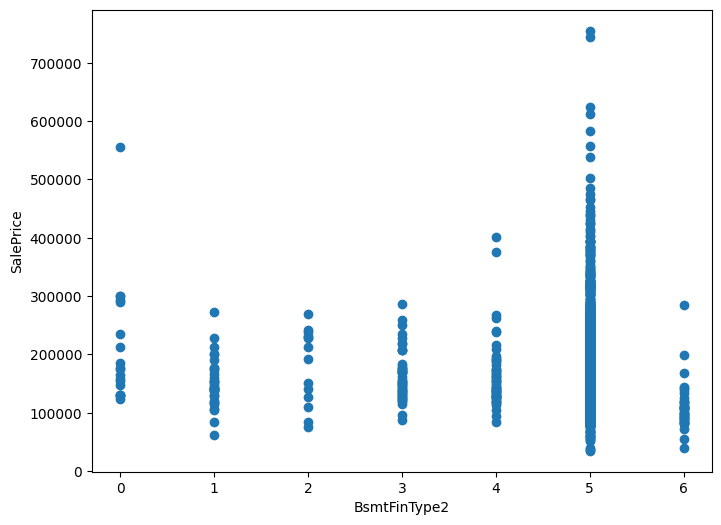

<Figure size 640x480 with 0 Axes>

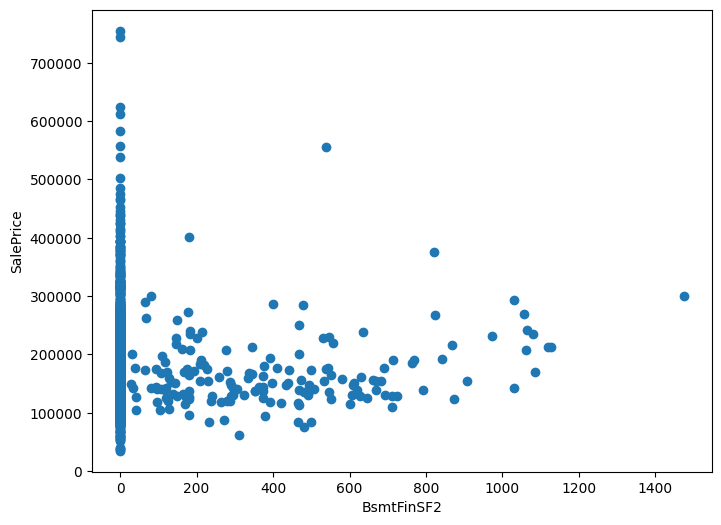

<Figure size 640x480 with 0 Axes>

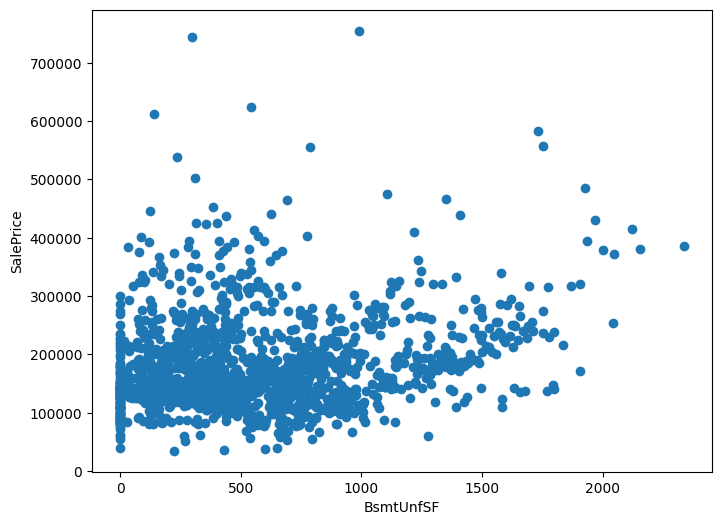

<Figure size 640x480 with 0 Axes>

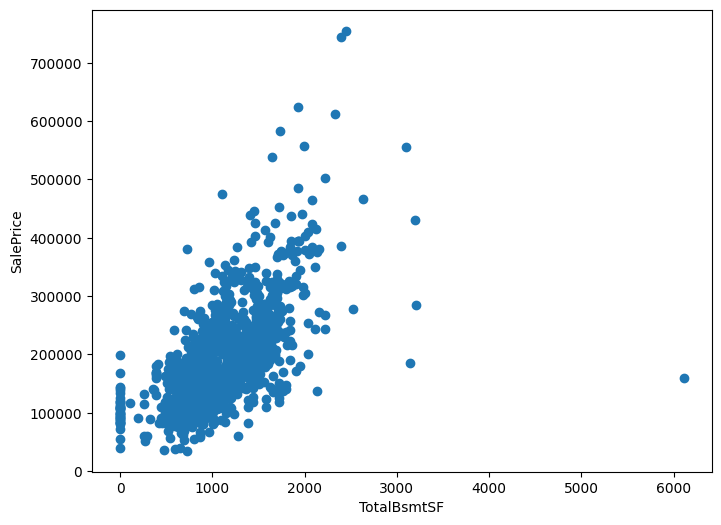

<Figure size 640x480 with 0 Axes>

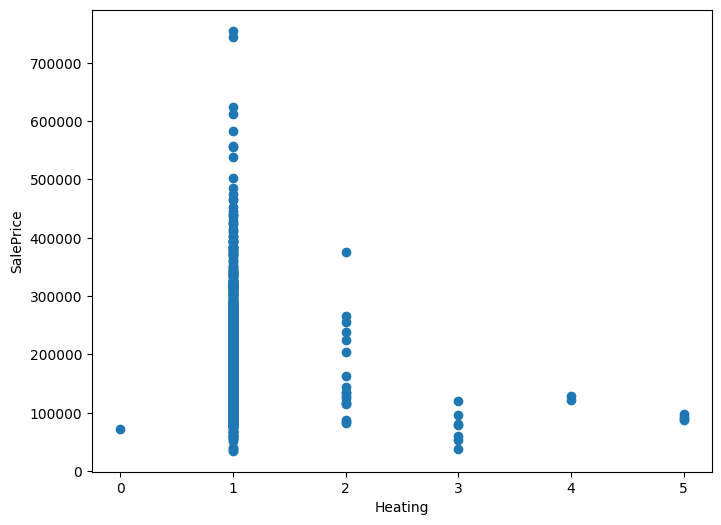

<Figure size 640x480 with 0 Axes>

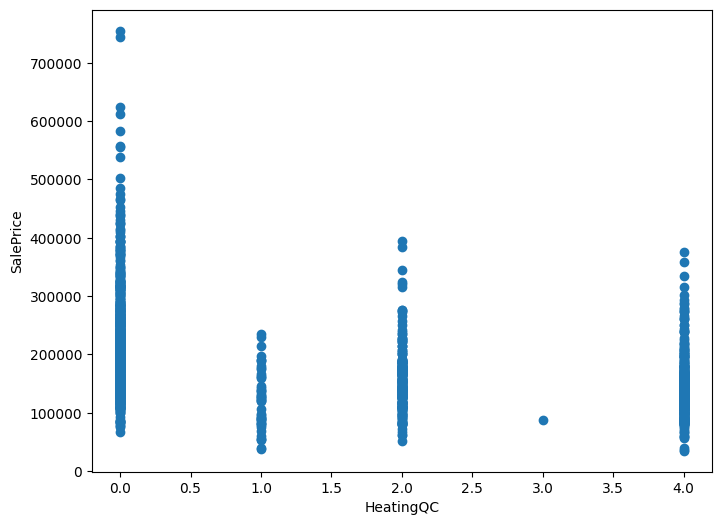

<Figure size 640x480 with 0 Axes>

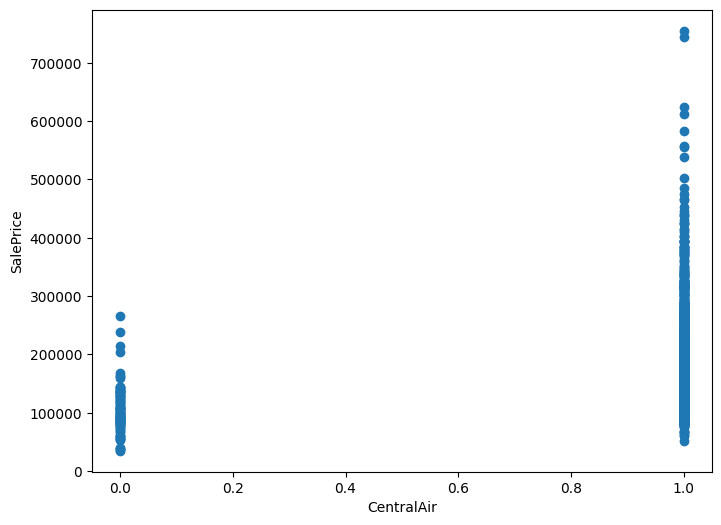

<Figure size 640x480 with 0 Axes>

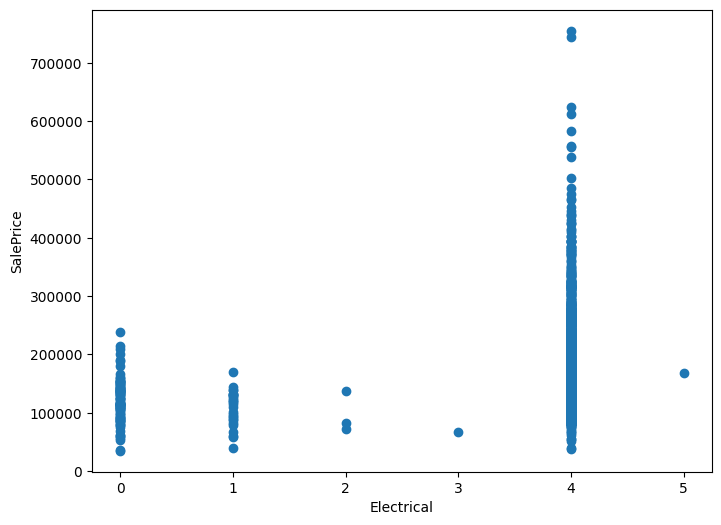

<Figure size 640x480 with 0 Axes>

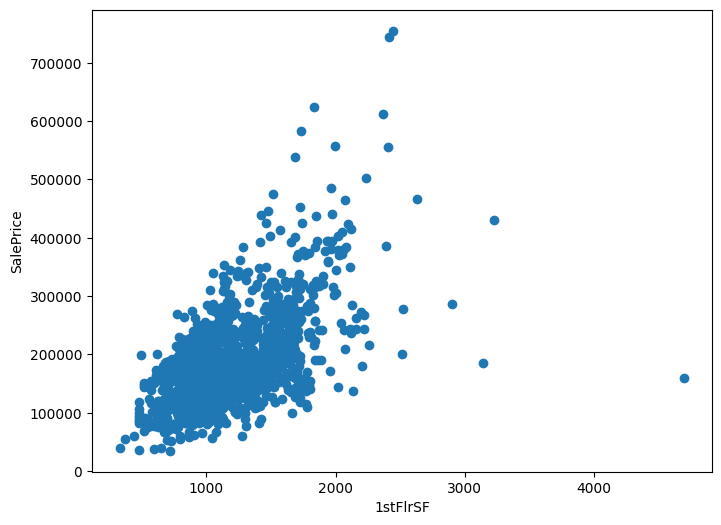

<Figure size 640x480 with 0 Axes>

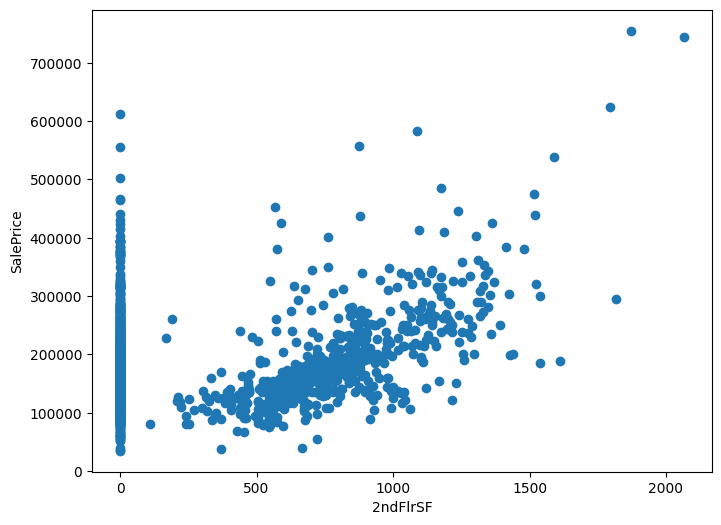

<Figure size 640x480 with 0 Axes>

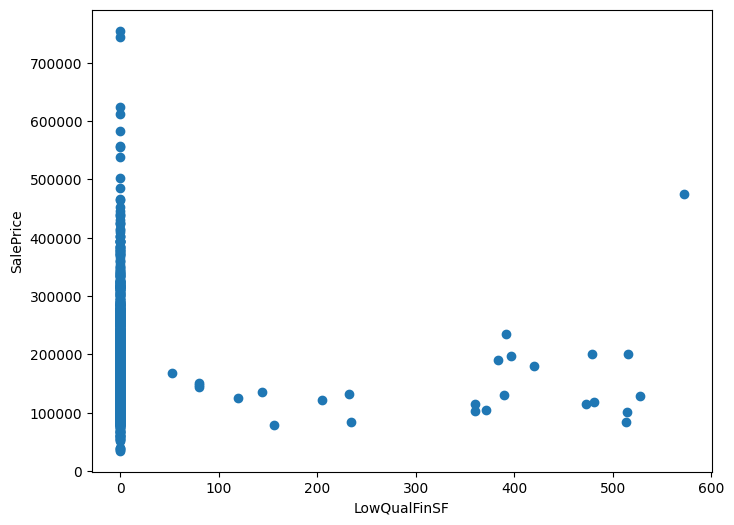

<Figure size 640x480 with 0 Axes>

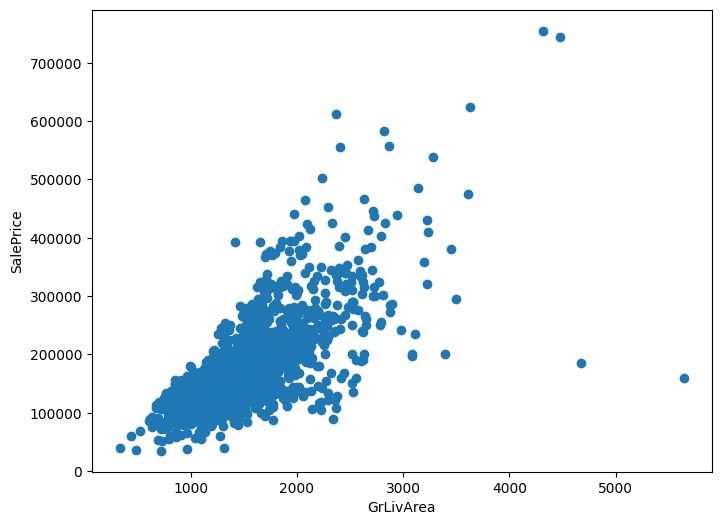

<Figure size 640x480 with 0 Axes>

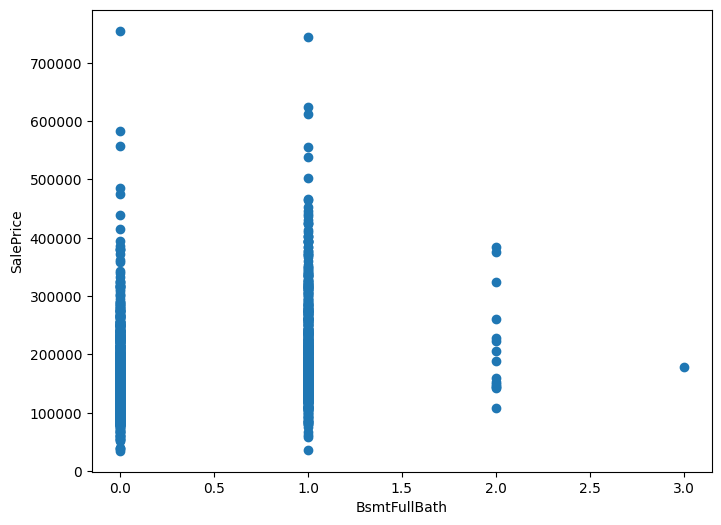

<Figure size 640x480 with 0 Axes>

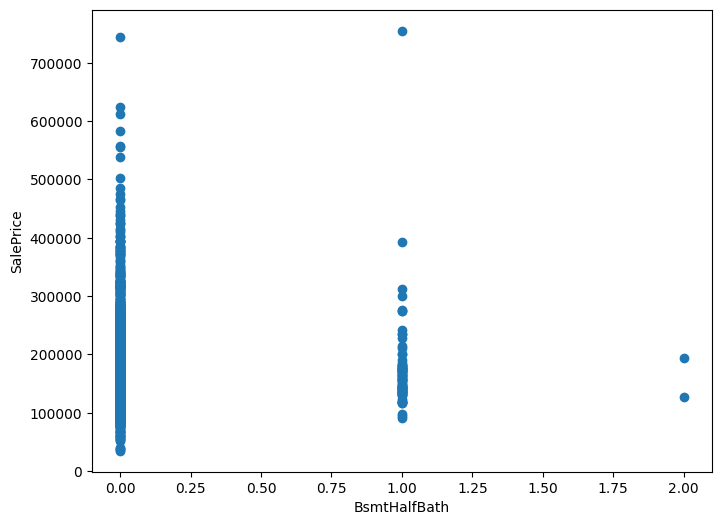

<Figure size 640x480 with 0 Axes>

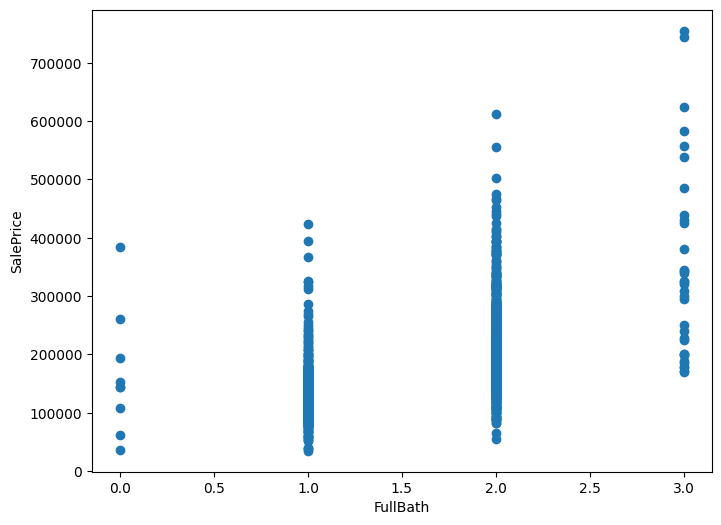

<Figure size 640x480 with 0 Axes>

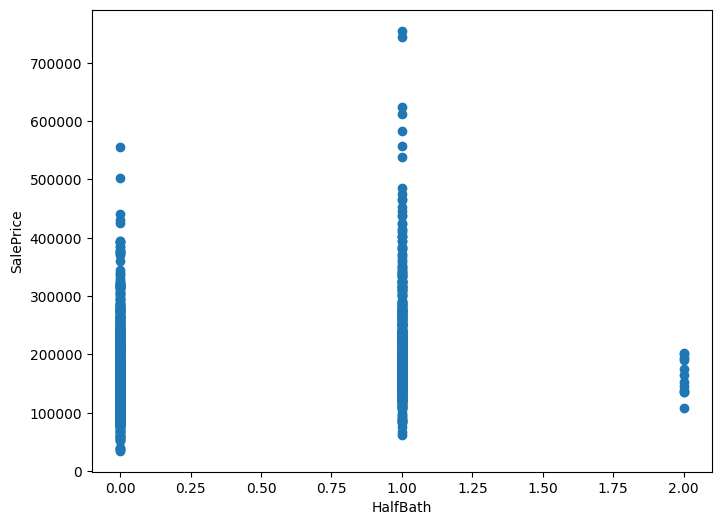

<Figure size 640x480 with 0 Axes>

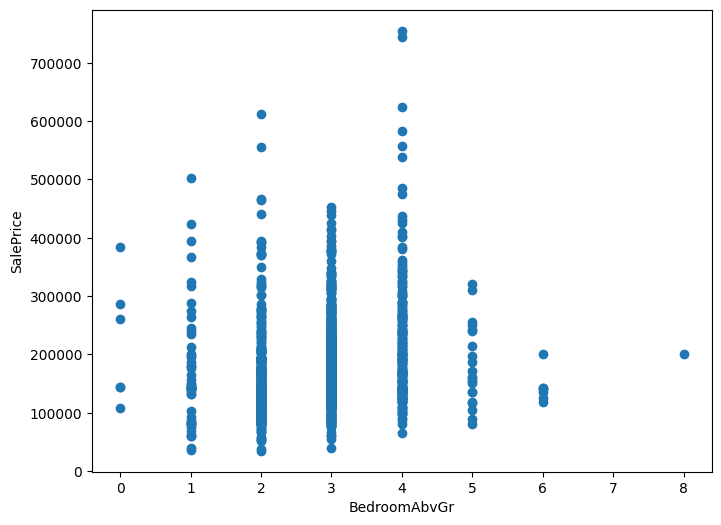

<Figure size 640x480 with 0 Axes>

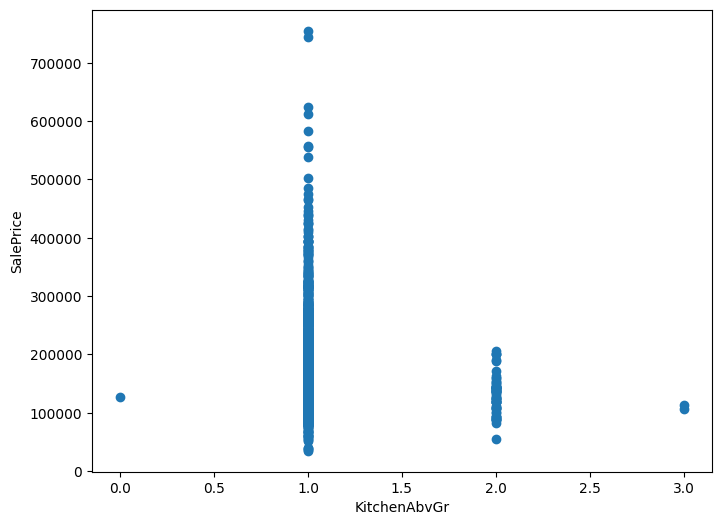

<Figure size 640x480 with 0 Axes>

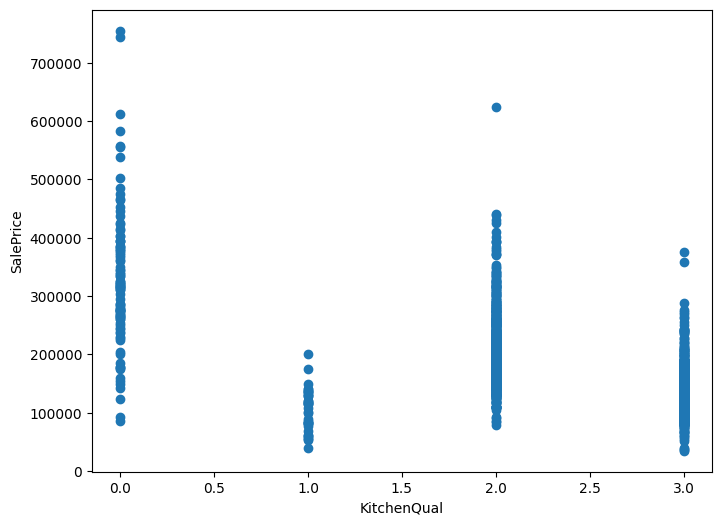

<Figure size 640x480 with 0 Axes>

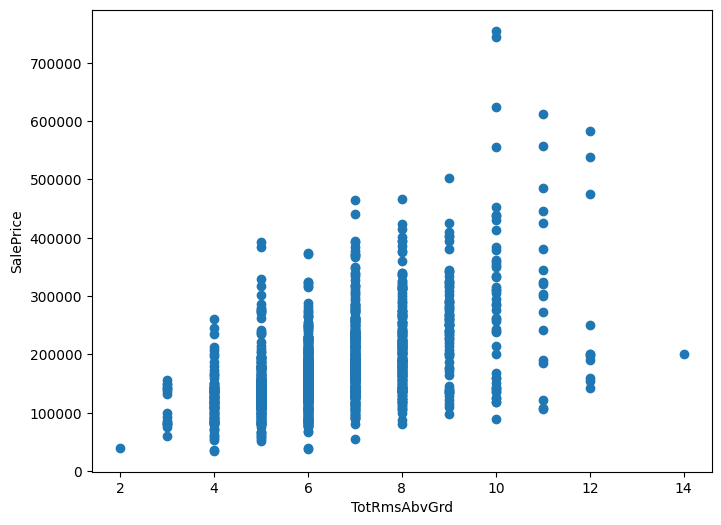

<Figure size 640x480 with 0 Axes>

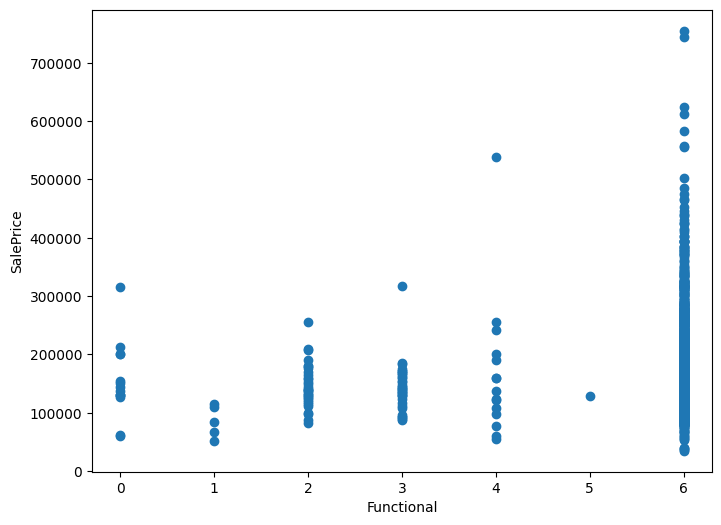

<Figure size 640x480 with 0 Axes>

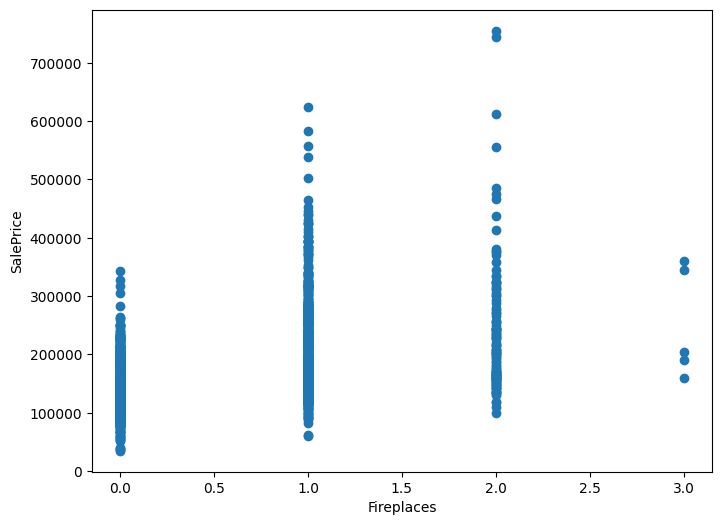

<Figure size 640x480 with 0 Axes>

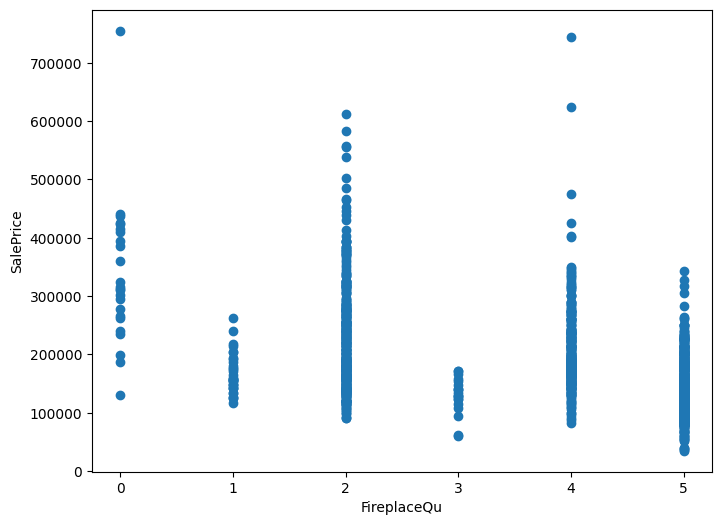

<Figure size 640x480 with 0 Axes>

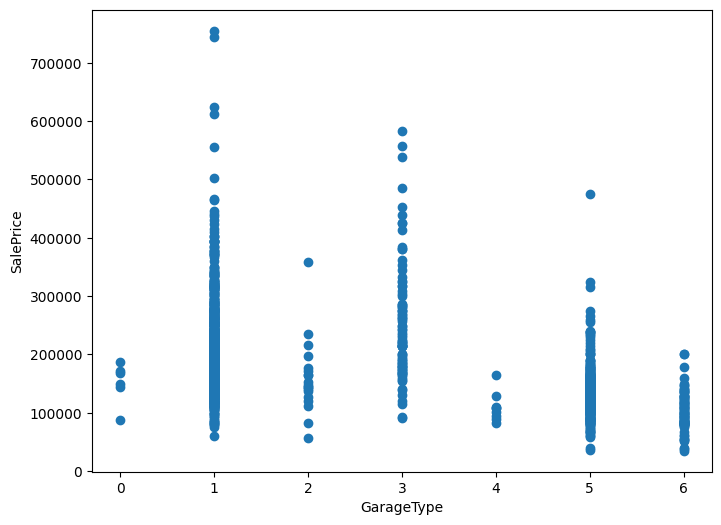

<Figure size 640x480 with 0 Axes>

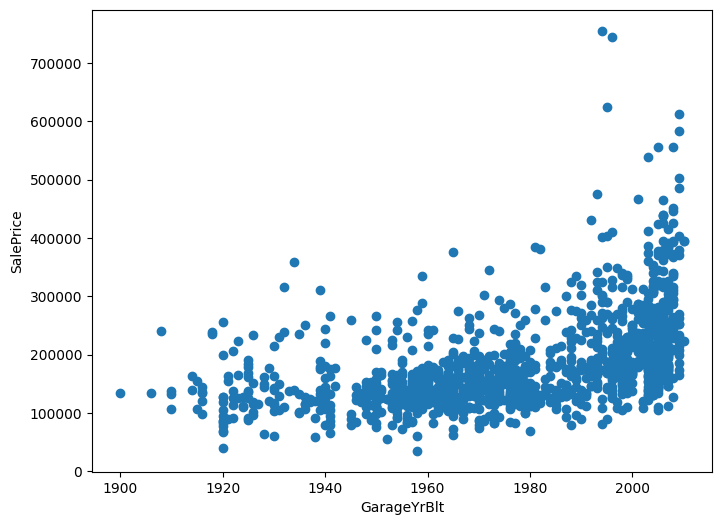

<Figure size 640x480 with 0 Axes>

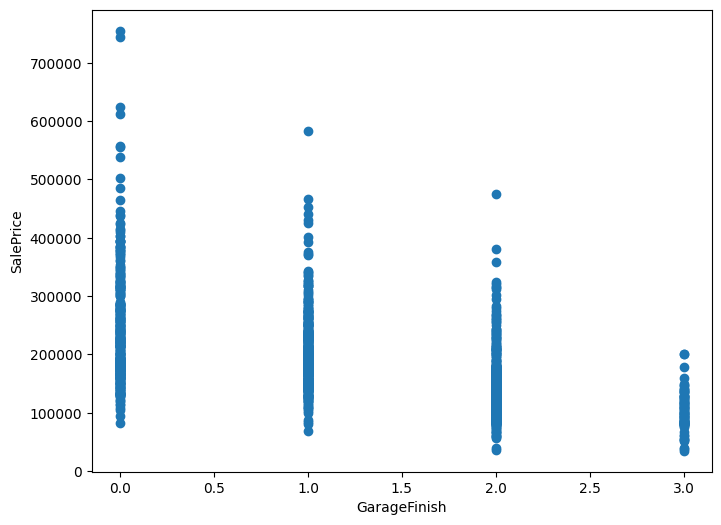

<Figure size 640x480 with 0 Axes>

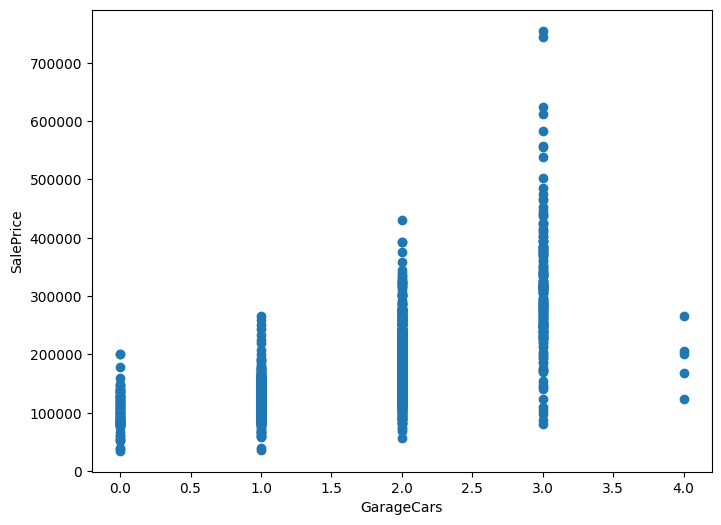

<Figure size 640x480 with 0 Axes>

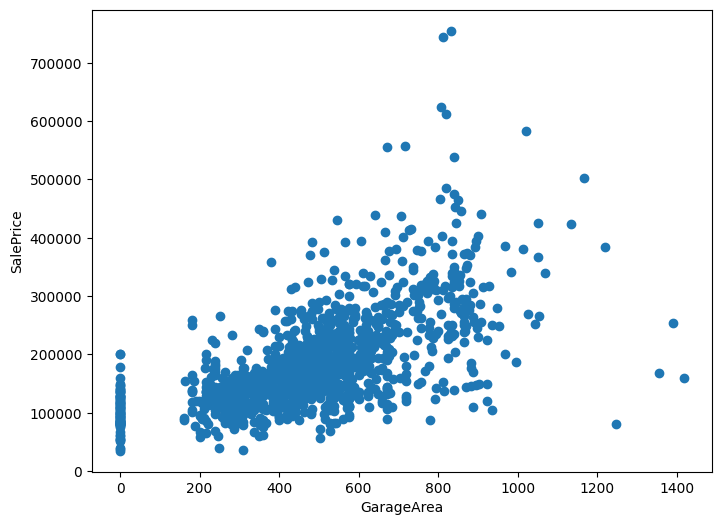

<Figure size 640x480 with 0 Axes>

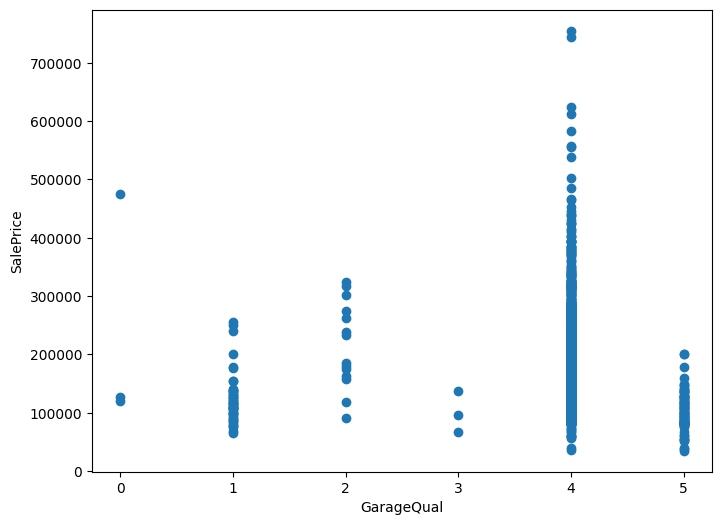

<Figure size 640x480 with 0 Axes>

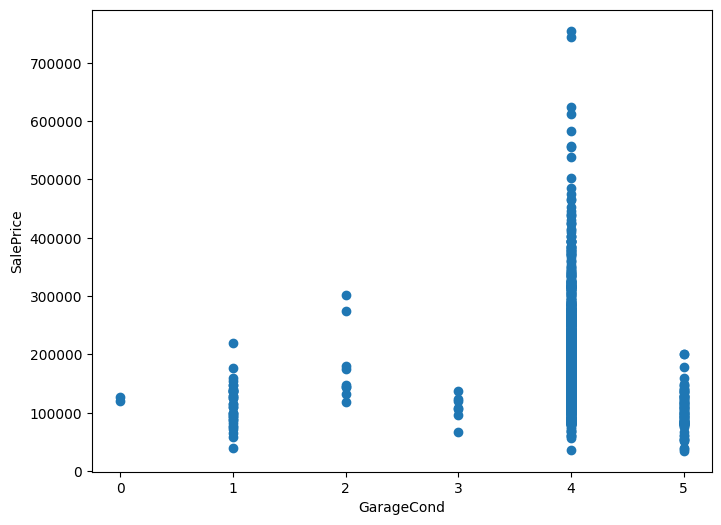

<Figure size 640x480 with 0 Axes>

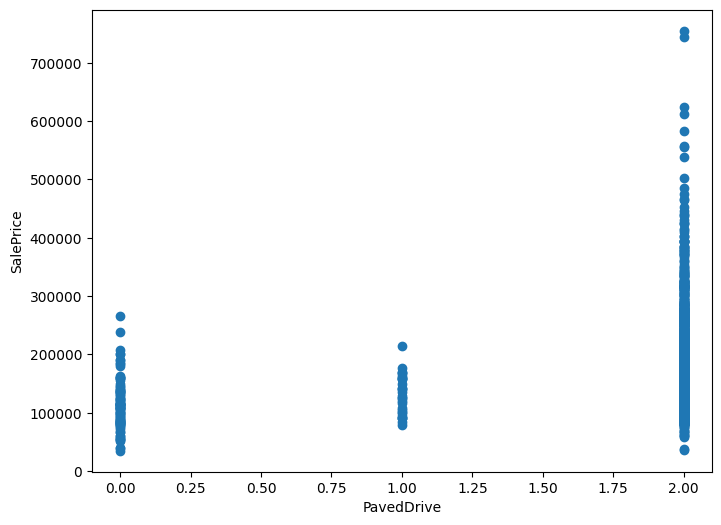

<Figure size 640x480 with 0 Axes>

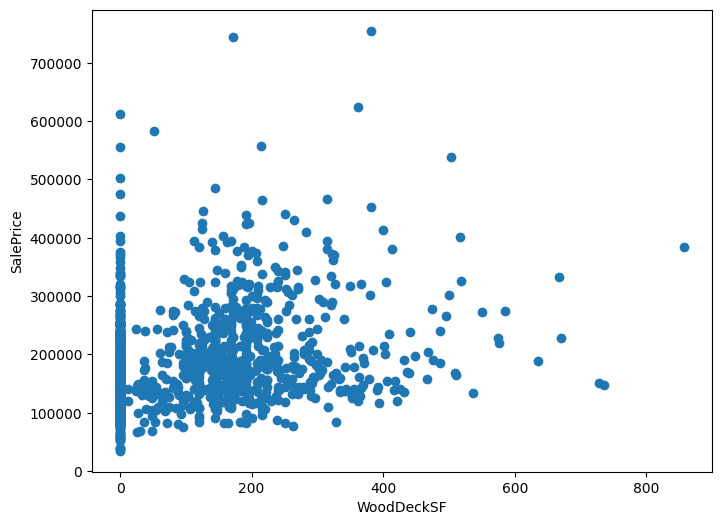

<Figure size 640x480 with 0 Axes>

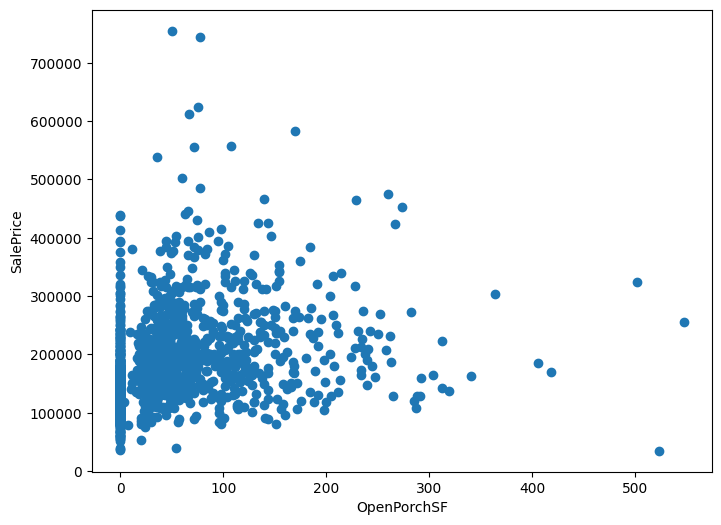

<Figure size 640x480 with 0 Axes>

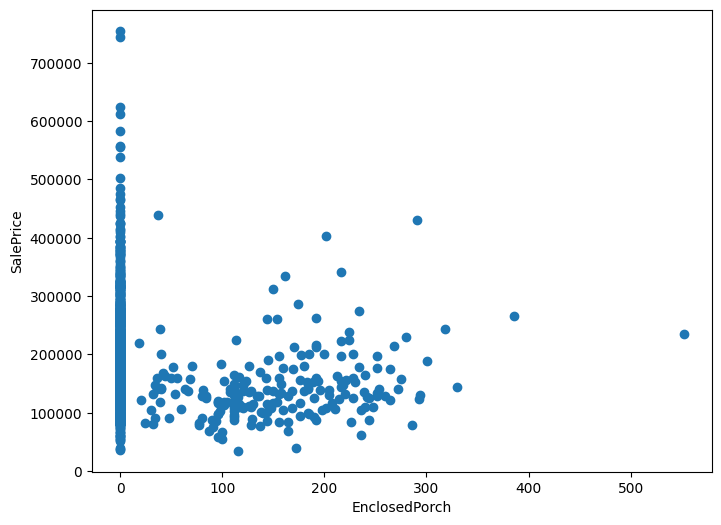

<Figure size 640x480 with 0 Axes>

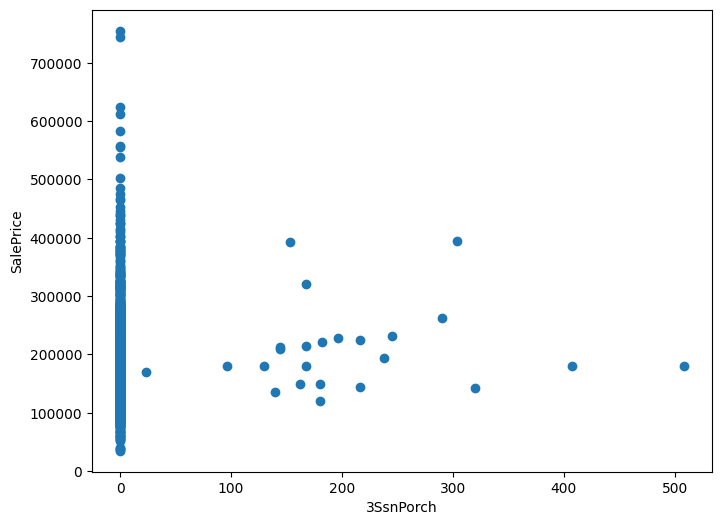

<Figure size 640x480 with 0 Axes>

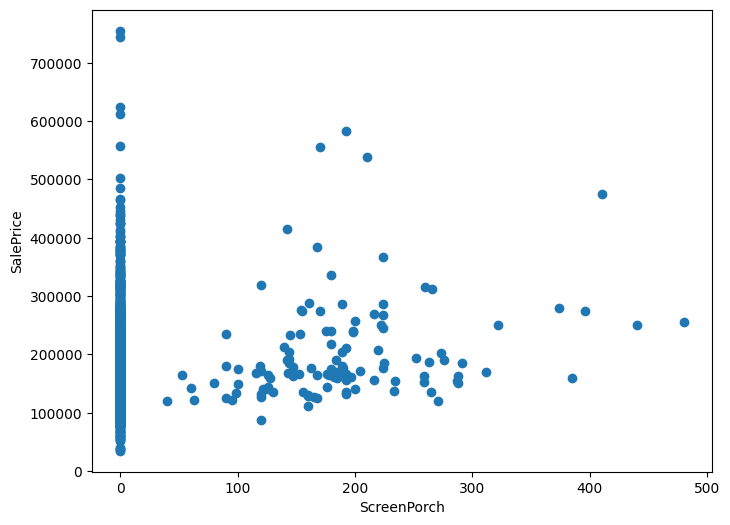

<Figure size 640x480 with 0 Axes>

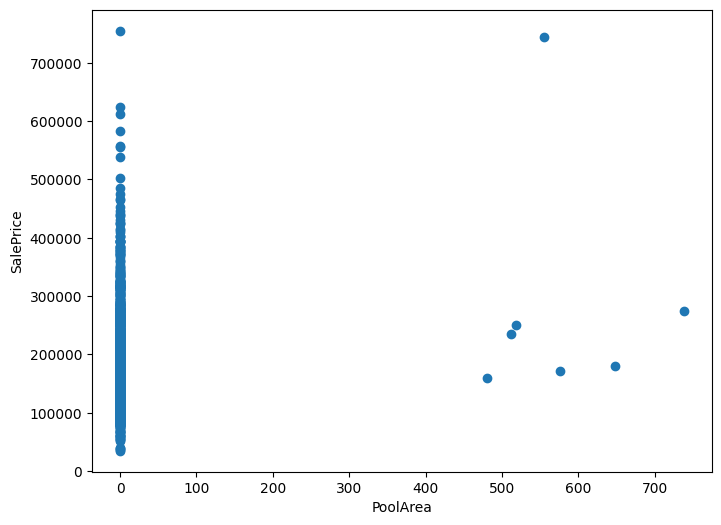

<Figure size 640x480 with 0 Axes>

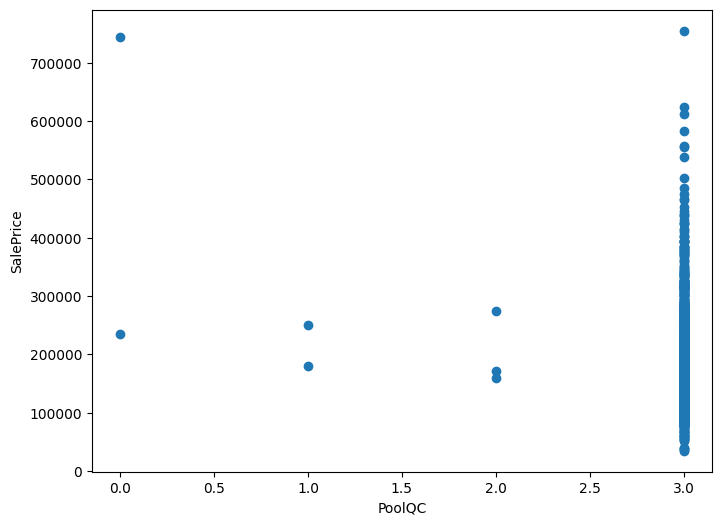

<Figure size 640x480 with 0 Axes>

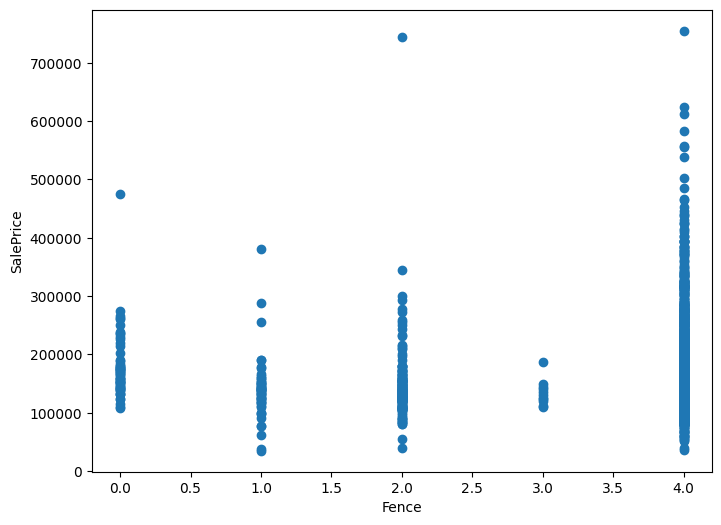

<Figure size 640x480 with 0 Axes>

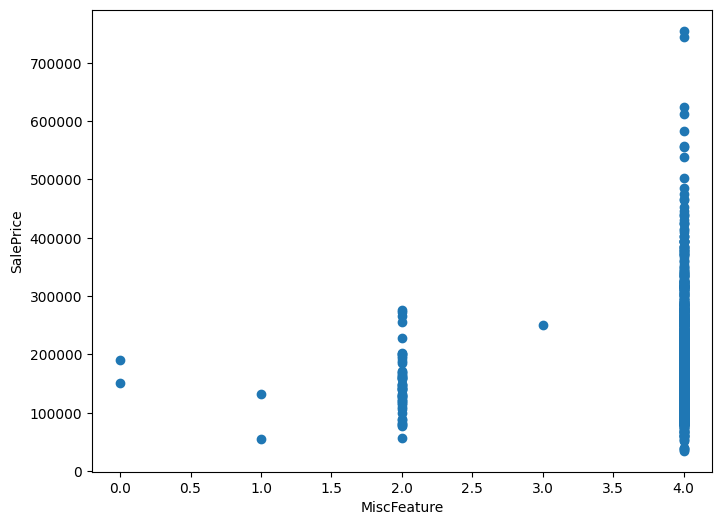

<Figure size 640x480 with 0 Axes>

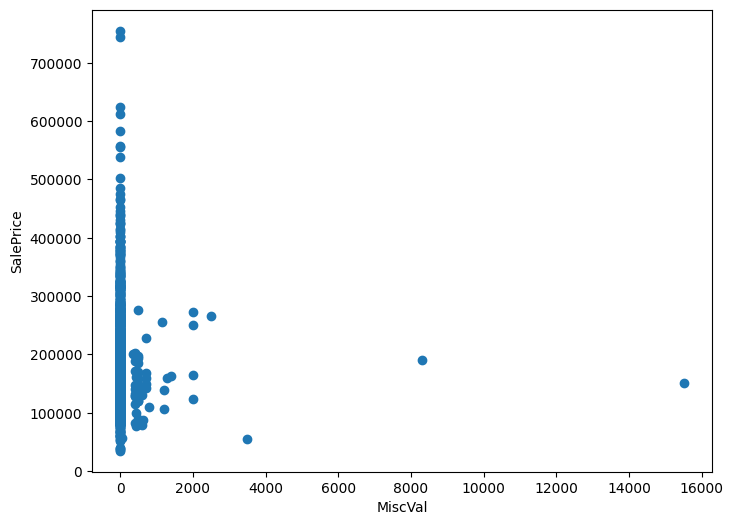

<Figure size 640x480 with 0 Axes>

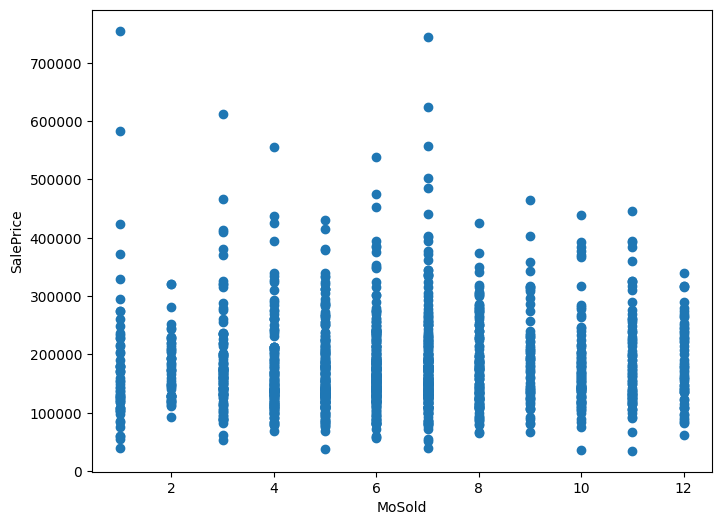

<Figure size 640x480 with 0 Axes>

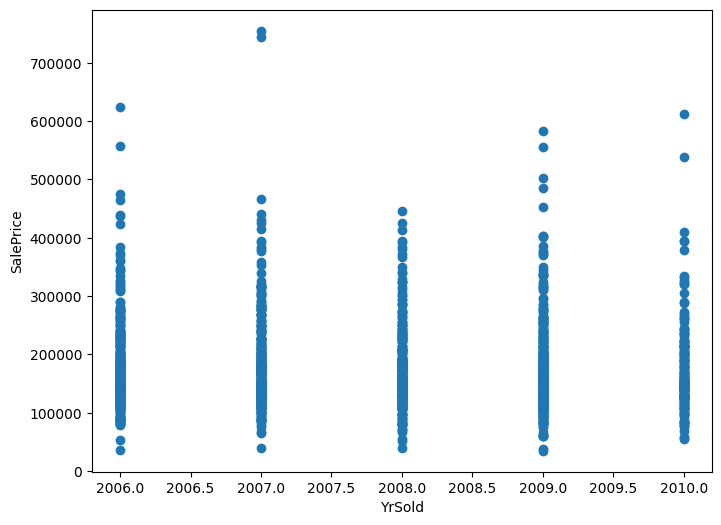

<Figure size 640x480 with 0 Axes>

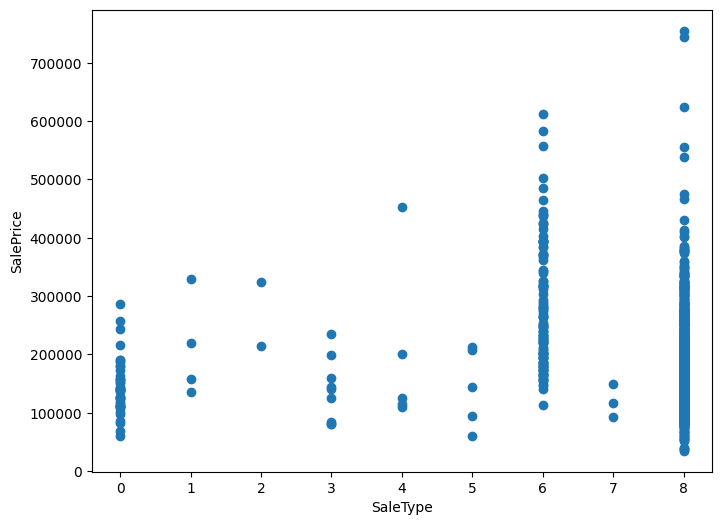

<Figure size 640x480 with 0 Axes>

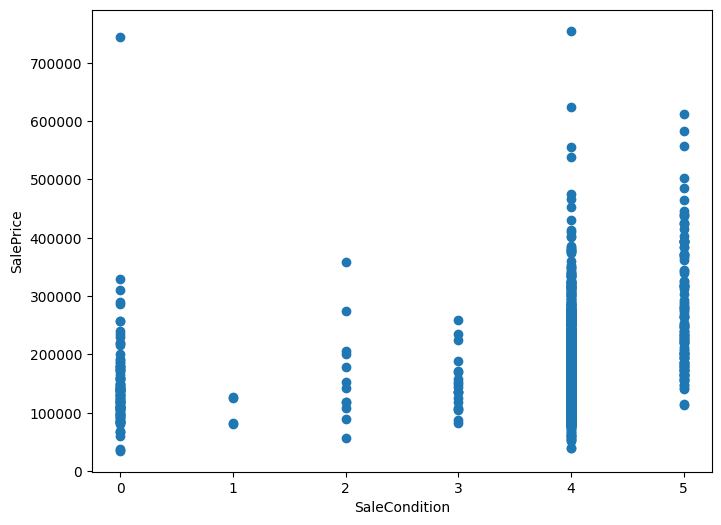

{'MSSubClass': (-0.08428413512659531, 0.007192252911733476), 'MSZoning': (-0.16687220265320646, -0.3349091697448212), 'LotFrontage': (0.35179909657067804, 0.4090755179546496), 'LotArea': (0.2638433538714056, 0.4564605833912115), 'Street': (0.04103553550004948, 0.045814187076882375), 'Alley': (0.13986774969168472, 0.13020727792213868), 'LotShape': (-0.25557987048712216, -0.30592329251981765), 'LandContour': (0.015453241660960342, -0.010233826409225452), 'Utilities': (-0.014314296147248806, -0.016709609503697546), 'LotConfig': (-0.06739602315941741, -0.07422513389231687), 'LandSlope': (0.05115224817946654, 0.05031026015605547), 'Neighborhood': (0.21085146582230319, 0.1656087356921405), 'Condition1': (0.09115491154092832, 0.18665598775650002), 'Condition2': (0.007512734036333064, 0.06162585451496644), 'BldgType': (-0.08559060818352927, -0.11993445018861337), 'HouseStyle': (0.18016262334399102, 0.2536691217897532), 'OverallQual': (0.7909816005838044, 0.8098285862017292), 'OverallCond': (-0

<Figure size 640x480 with 0 Axes>

In [48]:
# Separate labels from samples
X_train = encoded_data.drop(['SalePrice'], axis=1)
y_train = encoded_data['SalePrice']
print(X_train)
print(y_train)

# Find and graph correlation between all features and the labels

# Loop through features
noise_correlations = {}
for feature in X_train.columns:

  # Calculate correlation
  pearson_temp = X_train[feature].corr(y_train)
  spearman_temp = X_train[feature].corr(y_train, method='spearman')

  # Save correlation into array
  noise_correlations[feature] = (pearson_temp, spearman_temp)

  # Graph the correlation
  plt.figure(figsize=(8, 6))
  plt.scatter(X_train[feature], y_train)
  plt.xlabel(feature)
  plt.ylabel('SalePrice')
  plt.show()

  # Save each graph into an image file
  plt.savefig('corrs/' + feature + '_NoiseCorr.png')

# Observe features and remove using threshold on array
print(noise_correlations)

In [ ]:
# Feature to Feature noise comparison


In [ ]:
# Analyze feature's individual distributions
